# NLP Final Project: Amazon Reviews
By Gerald Lee (GL2668)

## Table of Contents
- [Load Dataset](#Load-Data)
- [Data Description](#Data-Description)
- [Text Pre-Processing](#Text-Pre-Processing)
- [Sentiment Analysis](#Sentiment-Analysis)
- [Predict Product Recommendation](#Predict-Product-Recommendation)
- [Topic Modelling](#Topic-Modelling)


***

### Load Data

In [1]:
# Check current directory
import os
cwd = os.getcwd()
print(cwd)

/Users/geraldlee/Documents/Natural Language Processing/Homework


In [2]:
# Read Data
import json
import pandas as pd
import gzip

# Unzip file
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

# Parse from json to pandas dataframe
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('AMAZON_FASHION.json.gz')

In [3]:
# Remove Unneccesary Columns
df = df.drop(['verified', 'reviewerID', 'asin', 'unixReviewTime', 'style', 'image'], axis = 1)

# Rename Columns
df = df.rename(columns={"overall": "rating", "reviewText": "review"})

# Convert object column to string
df["review"] = df["review"].astype('str')

In [4]:
# Save pandas dataframe as pickle object
import pickle
with open("data/amazon_fashion_reviews.pkl", 'wb') as f:
    pickle.dump(df, f)

In [5]:
# Read File
with open("data/amazon_fashion_reviews.pkl", 'rb') as f:
  df = pickle.load(f)

***

### Data Description

This dataset contains reviews from Amazon from May 1996 - Oct 2018. The dataset is focused on reviews under the category of Amazon Fashion, which refers to Amazon-branded fashion products. The data was obtained from [Ni Jian Mo]('https://nijianmo.github.io/amazon/index.html'), who has created a database of webscrapped Amazon reviews.

- 883,636 Rows, 6 Columns
    - `rating` is the Star-Rating
    - `reviewTime` is time of Rating \ Review
    - `reviewerName` is the name of the person who gave the Review
    - `review` is the Review
    - `summary` is the header for the Review
    - `vote` is the number of public votes for whether the Review was helpful or not

In [6]:
# Print Head
df.head()

,rating,reviewTime,reviewerName,review,summary,vote
0,5.0,"10 20, 2014",Tracy,Exactly what I needed.,perfect replacements!!,NaN
1,2.0,"09 28, 2014",Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",3
2,4.0,"08 25, 2014",Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,NaN
3,2.0,"08 24, 2014",Jodi Stoner,too tiny an opening,Two Stars,NaN
4,3.0,"07 27, 2014",Alexander D.,Okay,Three Stars,NaN


In [7]:
# Distribution of Ratings
df['rating'].value_counts(normalize = True)

5.0    0.526773
4.0    0.168996
1.0    0.121181
3.0    0.109809
2.0    0.073241
Name: rating, dtype: float64

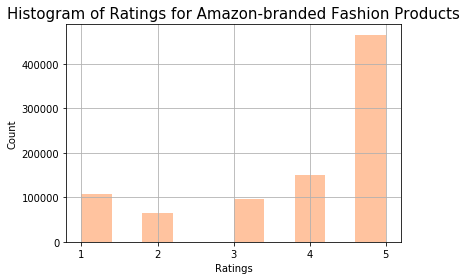

In [8]:
# Histogram of Ratings
import matplotlib.pyplot as plt
df['rating'].hist(color = "#ffc39f")

# Add title and axis names
plt.title("Histogram of Ratings for Amazon-branded Fashion Products", fontsize=15)
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.style.use('fivethirtyeight')
plt.show()

In [17]:
from scipy.stats import kurtosis
from scipy.stats import skew
import numpy as np
print("Mean: ",np.mean(df['rating']))
print("Median: ",np.median(df['rating']))
print("Kurtosis: ",kurtosis(df['rating']))
print("Skew: ",skew(df['rating']))

Kurtosis:  -0.41781126903706367
Skew:  -1.0089672535223233


### Text Pre-Processing

- Clean up the plain-text reviews so that NLP techniques can be applied

In [19]:
# Load necessary text mining libraries
import nltk
# Set stop words to english stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))
import re
import string
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
my_stem = WordNetLemmatizer() # Lemmatization

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/geraldlee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
# Text Cleaner Function
def text_cleaner(text):
    clean_text = re.sub('[^a-zA-Z]+', ' ', str(text)) # Remove Punctuations and Digits
    clean_text = [word.lower() for word in clean_text.split() if word not in stop_words] # Remove Stopwords & lowercase
    clean_text = [my_stem.lemmatize(word) for word in clean_text] # Stemming of Root words
    clean_text = ' '.join(clean_text) # Join back the words to form a sentence
    return clean_text

In [21]:
df['review'] = df['review'].apply(text_cleaner)

In [22]:
df.head()

,rating,reviewTime,reviewerName,review,summary,vote
0,5.0,"10 20, 2014",Tracy,exactly i needed,perfect replacements!!,NaN
1,2.0,"09 28, 2014",Sonja Lau,i agree review opening small i almost bent hoo...,"I agree with the other review, the opening is ...",3
2,4.0,"08 25, 2014",Kathleen,love i going order another pack keep work some...,My New 'Friends' !!,NaN
3,2.0,"08 24, 2014",Jodi Stoner,tiny opening,Two Stars,NaN
4,3.0,"07 27, 2014",Alexander D.,okay,Three Stars,NaN


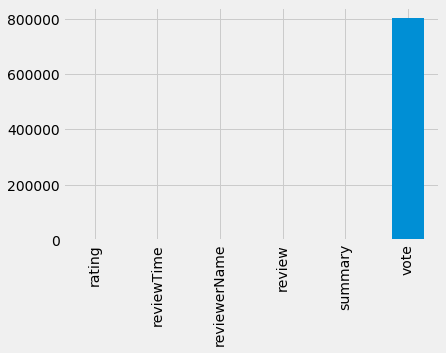

In [23]:
# Visualize missing Data
df.isna().sum().plot(kind = "bar")
plt.show()

### Sentiment Analysis
- Use AFINN lexicon
- Sentiment Score will be derived by taking the total of polarity scores per review
    - i.e. +5 + 6 +1 -1 -1 = +10 (positive)

In [24]:
from afinn import Afinn
afinn = Afinn(language='en')

In [25]:
# compute sentiment scores (polarity) and labels
afinn_sentiment_score = [afinn.score(i) for i in df['review']]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in afinn_sentiment_score]

# Append to dataframe
df['sentiment_score'] = afinn_sentiment_score
df['sentiment_category'] = sentiment_category

# Set as numerical
df['sentiment_score'] = df['sentiment_score'].astype('float')

In [26]:
# Save pandas dataframe as pickle object
import pickle
with open("data/amazon_fashion_reviews_final.pkl", 'wb') as f:
    pickle.dump(df, f)

In [27]:
# Read File
with open("data/amazon_fashion_reviews_final.pkl", 'rb') as f:
  df = pickle.load(f)

In [28]:
df.groupby(by=['rating']).describe()

sentiment_score                                                
                 count      mean       std   min  25%  50%  75%    max
rating                                                                
1.0           107080.0  0.575336  3.452717 -32.0 -1.0  0.0  2.0  138.0
2.0            64718.0  2.093173  3.789818 -17.0  0.0  1.0  4.0   56.0
3.0            97031.0  3.257134  4.333394 -17.0  0.0  2.0  5.0  112.0
4.0           149331.0  5.215642  5.160539 -24.0  2.0  4.0  7.0  110.0
5.0           465476.0  6.075914  5.510911 -21.0  3.0  5.0  8.0  954.0

In [29]:
from scipy.stats import kurtosis
from scipy.stats import skew
import numpy as np
print("Mean: ",np.mean(df['sentiment_score']))
print("Median: ",np.median(df['sentiment_score']))
print("Kurtosis: ",kurtosis(df['sentiment_score']))
print("Skew: ",skew(df['sentiment_score']))

Mean:  4.662740087547361
Median:  3.0
Kurtosis:  1118.1266901131914
Skew:  8.537818096857732


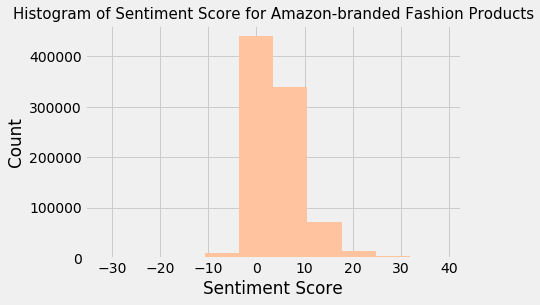

In [35]:
# Histogram of Sentiment Score
df['sentiment_score'][df['sentiment_score'] < 40].hist(color = '#ffc39f')

# Add title and axis names
plt.title("Histogram of Sentiment Score for Amazon-branded Fashion Products", fontsize=15)
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.style.use('fivethirtyeight')
plt.show()

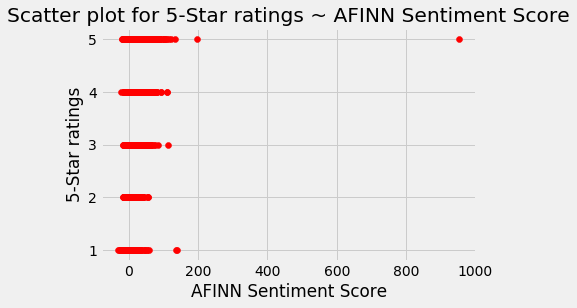

In [36]:
x = df['sentiment_score']
y = df['rating']

plt.scatter(x, y, color = 'red')
plt.title('Scatter plot for 5-Star ratings ~ AFINN Sentiment Score')
plt.xlabel('AFINN Sentiment Score')
plt.ylabel('5-Star ratings')
plt.show()

### Print Samples of Reviews from Sentiment Analysis

In [21]:
pd.options.display.max_colwidth = 150

In [22]:
# Where sentiment scores are really positive, > 50
df[df['sentiment_score'] > 50][['review', 'rating', 'sentiment_score']].head(5)

,review,rating,sentiment_score
595,these shirt great v neck fit perfectly comfortable look great they used black shirt ever needed i love wear every day shirt the nice cotton design...,5.0,77.0
7839,this sort watch noticed some love hate seen review mixed review good reason this beautiful watch design awesome weight somewhat light feel plastic...,4.0,78.0
13783,after searching perfect dr scholl insert running shoe original inside wore i decided settle pair designated work shoe i read review multiple site ...,4.0,73.0
15303,an ex football player past prime lb size d medium arch i recently diagnosed plantar fasciitis my orthopedist recommended daily stretching exercise...,3.0,64.0
27286,after searching perfect dr scholl insert running shoe original inside wore i decided settle pair designated work shoe i read review multiple site ...,4.0,73.0


In [23]:
# Where sentiment scores are negative, -10
df[(df['sentiment_score'] < -10)][['review', 'rating', 'sentiment_score']]

,review,rating,sentiment_score
2433,frog small cute totally uncomfortable others lost year ordering one mistake hurt soooooo badly putting always hard finally broke bother find diffe...,3.0,-14.0
2533,i always bought bostonian wingtips i could wear year sol replaced wear year they broke well fit like glove but particular shoe awful i mean bad th...,1.0,-13.0
3216,this horrible buy horrible material all wrinkly skirt stuck together pulled apart skirt changed color old packing looked used i think completely d...,1.0,-12.0
4690,nothing spectacular made china warning warning this product contains chemical know state california cause cancer birth defect reproductive harm th...,2.0,-15.0
8163,this wig terrible and itchy i dissatisfied disappointed item it ugly ratty itchy wig total waste money i work well known retail chain wig part hal...,1.0,-18.0
...,...,...,...
876220,sewing poorly done sleeve tight body loose raise arm neck area shirt looked horrible bad sewing,1.0,-11.0
877114,i terribly sad disappointed product it is cheaply made and horrible i purchased daughter birthday broke heart wore first time now i money cheap ho...,1.0,-24.0
877724,class a no construction all working part metal metal ie thread wood strip beachwood much harder denser close grained wood either pine soft hard ri...,4.0,-13.0
880533,the brand hb it brand called otb and colour absolutely nothing advertised it horrible shade bright indigo blue i sooo upset order hate it hate it ...,1.0,-13.0


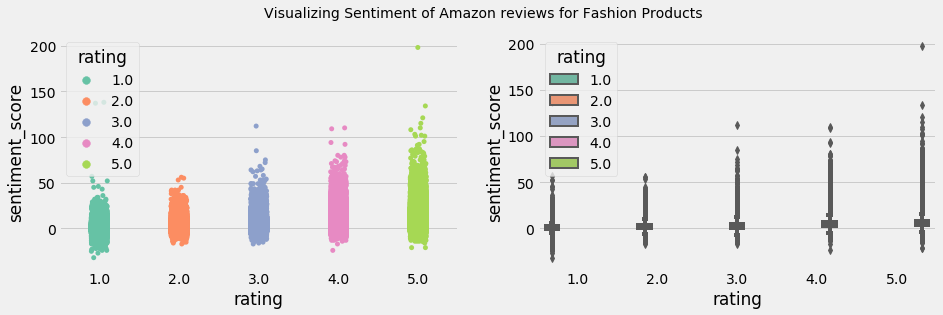

In [24]:
# Visualize the distribution of sentiment scores based on ratings
import seaborn as sns
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='rating', y="sentiment_score", 
                   hue='rating', data=df[df['sentiment_score'] < 200], palette="Set2", ax=ax1)
bp = sns.boxplot(x='rating', y="sentiment_score", 
                 hue='rating', data=df[df['sentiment_score'] < 200], palette="Set2", ax=ax2)
t = f.suptitle('Visualizing Sentiment of Amazon reviews for Fashion Products', fontsize=14)

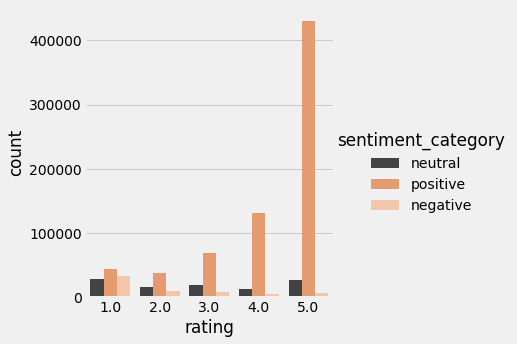

In [25]:
# Visualization continued
fc = sns.catplot(x="rating", hue="sentiment_category", 
                 data=df[df['sentiment_score'] < 40], kind="count", 
                 palette={"negative": "#FFC39F", 
                          "positive": "#F7965C", 
                          "neutral": "#434343"})

In [29]:
# Products that have low star ratings but positive sentiment
df[(df['rating'] == 1) & (df['sentiment_score'] > 0)].sample(10)

,rating,reviewTime,reviewerName,review,summary,vote,sentiment_score,sentiment_category
445247,1.0,"03 13, 2015",Jorge,the quality poor look nice picture look cheap material whe see,One Star,NaN,3.0,positive
329401,1.0,"01 18, 2016",Kelly King,it nice two small i need xl,One Star,NaN,3.0,positive
550786,1.0,"05 26, 2016",Cute and fun. Can hardly put it down.,save money got christmas by january stopped working regardless much kinetic motion applied beware return policy,Look elsewhere.,NaN,1.0,positive
738288,1.0,"12 4, 2016",ijamlive,interesting keep hand warm still hard move finger material inside really thick doesnt let move finger much also let hand stay warm returning product,material inside thick enough to make your hands look ugly also definitely not warm.,3,3.0,positive
466650,1.0,"09 13, 2015",Stephanie Taylor,expected shoulder cover best,don't.,NaN,3.0,positive
567288,1.0,"02 3, 2015",trina,nice coat come small sleeve short,One Star,2,3.0,positive
837331,1.0,"05 26, 2016",Meli,shirt super cute but run super small order size an extra large like u m i wear large ordered one size hoping best flow like snug i wanted work,Bummed,NaN,17.0,positive
678055,1.0,"05 19, 2016",jk,i bought gift i getting around posting review this ridiculously small i bought xl think not even medium this useless i bought go back maybe i upda...,COMPLETELY MISMARKED SIZES. 2XL IS ACTUALLY A MEDIUM.,NaN,2.0,positive
129579,1.0,"12 28, 2015",Nicola,enormous i know supposed baggy material rather flimsy small fit xl daughter,ENORMOUS. I know it's supposed to be baggy but ...,NaN,1.0,positive
529691,1.0,"06 30, 2015",Miranda,thin look nice ha sitting closet since arrived i worn,Thin,NaN,4.0,positive


In [30]:
# Save pandas dataframe as pickle object
import pickle
with open("data/amazon_fashion_reviews.pkl", 'wb') as f:
    pickle.dump(df, f)

### Predict Product Recommendation

- Use logistic regression to Predict Product Recommendations based on the text reviews
- Products with rating 4 and above will be classified as recommended and less than 4 as not recommended

In [31]:
# helper function to plot top positive and negative coefficients

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")

In [32]:
# Create a new column
# If rating is 4 and above, the product is recommended, it is not recommended if it is 3 and below
df['recommend'] = [1 if x >= 4 else 0 for x in df['rating']]

In [33]:
df.head()

,rating,reviewTime,reviewerName,review,summary,vote,sentiment_score,sentiment_category,recommend
0,5.0,"10 20, 2014",Tracy,exactly i needed,perfect replacements!!,NaN,0.0,neutral,1
1,2.0,"09 28, 2014",Sonja Lau,i agree review opening small i almost bent hook expensive earring trying get higher end seen would buy price sending back,"I agree with the other review, the opening is ...",3,1.0,positive,0
2,4.0,"08 25, 2014",Kathleen,love i going order another pack keep work someone including always losing back earring i understand fish hook earring just wish tiny bit longer,My New 'Friends' !!,NaN,1.0,positive,1
3,2.0,"08 24, 2014",Jodi Stoner,tiny opening,Two Stars,NaN,0.0,neutral,0
4,3.0,"07 27, 2014",Alexander D.,okay,Three Stars,NaN,0.0,neutral,0


In [34]:
# Vectorize text review
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df = 20).fit(df['review'])
X = vect.transform(df['review'])

print("X:\n{}".format(repr(X)))

y = df['recommend']

X:
<883636x10500 sparse matrix of type '<class 'numpy.int64'>'
	with 11690190 stored elements in Compressed Sparse Row format>


In [35]:
print(vect)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=20,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)


In [36]:
feature_names = vect.get_feature_names()
print("First 50 features:\n{}".format(feature_names[:10]))
print("Features 20 to 30:\n{}".format(feature_names[20:30]))
print("Every 50th feature:\n{}".format(feature_names[::50]))

First 50 features:
['aa', 'aaa', 'aaaa', 'ab', 'abalone', 'abd', 'abdomen', 'abdominal', 'ability', 'abit']
Features 20 to 30:
['absolutley', 'absolutly', 'absorb', 'absorbant', 'absorbent', 'absorbing', 'absorbs', 'absorption', 'abstract', 'absurd']
Every 50th feature:
['aa', 'accessorizing', 'adapt', 'advertisement', 'ahh', 'alleviated', 'amethyst', 'antenna', 'appraisal', 'around', 'associate', 'attraction', 'aweful', 'balaclava', 'base', 'beast', 'belief', 'bezel', 'bizarre', 'blood', 'bonnet', 'bound', 'break', 'broader', 'bulb', 'busted', 'cami', 'career', 'catsuit', 'challenged', 'checkout', 'chintzy', 'circumference', 'clevage', 'clutter', 'coloured', 'company', 'compressing', 'connector', 'contoured', 'corner', 'coupon', 'crawler', 'crocheted', 'cumbersome', 'czs', 'date', 'deck', 'del', 'describe', 'development', 'dimension', 'discoloration', 'dissatisfaction', 'documentation', 'downpour', 'drift', 'dupe', 'easy', 'elaborate', 'embossed', 'engraving', 'escape', 'evil', 'exist

In [37]:
# Set up training and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

print(X_train.shape)
print(y_train.shape)

(662727, 10500)
(662727,)


In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

scores = cross_val_score(LogisticRegression(max_iter = 1000), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.88


In [39]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter = 1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

/Users/geraldlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/geraldlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Best cross-validation score: 0.88
Best parameters:  {'C': 1}
Test score: 0.88


In [41]:
# Test model and print results
from sklearn.metrics import classification_report

logreg = LogisticRegression(C=1, max_iter = 1000).fit(X_train,y_train)
y_pred = logreg.predict(X_test) # y_pred includes your predictions

print(classification_report(y_test, y_pred)) # precision recall and f1
print("Accuracy score: {:.3f}".format(logreg.score(X_test, y_test))) #accuracy

              precision    recall  f1-score   support

           0       0.84      0.75      0.79     66986
           1       0.90      0.94      0.92    153923

    accuracy                           0.88    220909
   macro avg       0.87      0.84      0.85    220909
weighted avg       0.88      0.88      0.88    220909

Accuracy score: 0.880


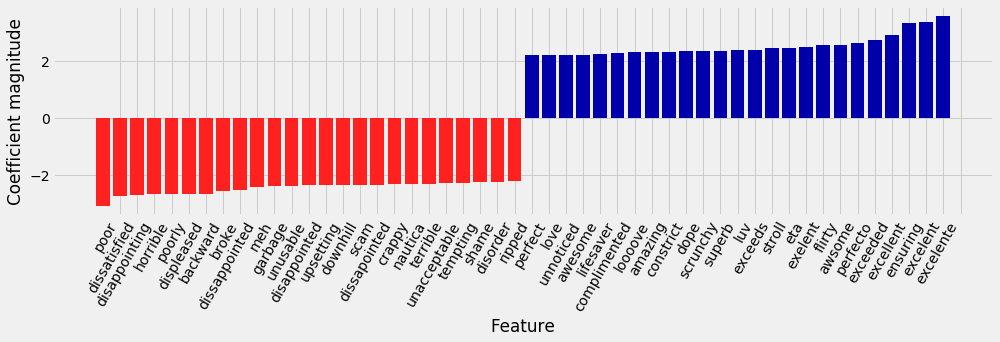

In [42]:
# Inspect model by visualizing the coefficients
coefs = LogisticRegression(C=1, max_iter = 1000).fit(X_train,y_train).coef_

visualize_coefficients(coefs, feature_names, n_top_features=25)

### Topic Modelling

- Use LDA (Unsupervised learning method) to break reviews into different topics

In [64]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation

vect = CountVectorizer(max_features=10000, max_df=.50)
X = vect.fit_transform(df['review'].sample(1000))

lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=1234)

document_topics = lda.fit_transform(X)

In [65]:
lda.components_.shape

(10, 2745)

In [66]:
import mglearn
# Invert rows to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
it            size          fit           nice          love          
this          like          the           very          great         
the           it            perfect       wear          the           
dress         the           dress         cute          my            
little        nice          it            gift          watch         
would         small         little        so            size          
size          shirt         would         would         good          
well          ordered       well          comfortable   quality       
product       love          cute          beautiful     well          
look          ring          expected      this          made          


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
good